In [164]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pysptools.util as util
import pysptools.eea as eea
import pysptools.classification as clssf
import pysptools.abundance_maps as amap
import pysptools.noise.dnoise as denoise
import os

NORMALIZATION_MAX_VALS_FROM_TRAINING_SET = [393.26,15.995,830.29,947.27,23.955,1293.715]

In [165]:
dataCubes = np.load('../TestDataAnalysis/meteoriteDataCubes.npy').item()
backgroundCubes = np.load('../TestDataAnalysis/backgroundDataCubes.npy').item()

#Removing two insane outliers. Must have been artifacts of moving with my hand. 
dataCubes['Toluca'][0][12] = dataCubes['Toluca'][0][11]
dataCubes['Gibeon'][1][14] = dataCubes['Gibeon'][1][13]

In [166]:
def addBackgroundColumnsToData(): 
    for sample in dataCubes: 
        VelvetClose = np.repeat([[backgroundCubes['VelvetClose(UseForAllSmall)']]], len(dataCubes[sample]), axis=0); 
        VelvetFar = np.repeat([[backgroundCubes['velvet_background']]], len(dataCubes[sample]), axis=0); 
        dataWithBackground = np.concatenate((dataCubes[sample],VelvetClose,VelvetFar), axis=1)
        dataCubesWithBackground[sample] = dataWithBackground

In [167]:
dataCubesWithBackground = {}
addBackgroundColumnsToData()

In [168]:
def getNormalizationMaxVals(cube):
    samples = []
    for sample in cube:
        for row in cube[sample]:
            samples.append(row)
    samples = np.reshape(samples,(391,6))
    return np.max(np.transpose(samples), axis=1)
     
    #np.reshape(samples, (51,17,6))
        

In [169]:
NormalizationMaxVals = getNormalizationMaxVals(dataCubesWithBackground)
print NormalizationMaxVals

[  82.58    8.    145.24  181.04    6.25  417.09]


In [170]:
def NormalizeCubePerColumn(cube):
    normalized_cube = cube 
    for sample in normalized_cube: 
        for i, row in enumerate(normalized_cube[sample]): 
            normalized_cube[sample][i] = cube[sample][i] /  NormalizationMaxVals
    #print cube
    return normalized_cube
normalizedDataCubesWithBackground = NormalizeCubePerColumn(dataCubesWithBackground)    
print normalizedDataCubesWithBackground['Chondrite']

[[[ 0.54093001  0.8575      0.58331038  0.34705038  0.3328      0.09012443]
  [ 0.54093001  0.8575      0.59164142  0.35296067  0.3328      0.09302549]
  [ 0.54093001  0.8575      0.59164142  0.35296067  0.3328      0.09302549]
  [ 0.54093001  0.8575      0.59164142  0.35296067  0.3328      0.09302549]
  [ 0.55739889  0.8575      0.59997246  0.35296067  0.3328      0.09302549]
  [ 0.57374667  0.8575      0.59997246  0.35881573  0.3328      0.11338081]
  [ 0.65572778  0.8575      0.6416965   0.38825674  0.4992      0.1627946 ]
  [ 0.70489223  0.8575      0.71667585  0.44117322  0.4992      0.18022489]
  [ 0.72124001  0.8575      0.72500689  0.44708352  0.4992      0.18314992]
  [ 0.72124001  0.8575      0.74166896  0.46470393  0.4992      0.20348126]
  [ 0.72124001  0.8575      0.75833104  0.47646929  0.4992      0.19767916]
  [ 0.72124001  0.8575      0.76666208  0.48823464  0.4992      0.19477811]
  [ 0.70489223  0.8575      0.76666208  0.48823464  0.4992      0.19767916]
  [ 0.704892

In [171]:
def NFINDR(sample): 
    NFINDR = eea.NFINDR()
    NFINDR.extract(sample, q=2)
    return NFINDR.get_idx()
    #NFINDR.display()

In [172]:
#Endmembers per row
def endmembersPerRow(cube):
    for sample in cube: 
        print sample + ':'
        for i, row in enumerate(cube[sample]): 
            print NFINDR(np.array([row]))
 

In [173]:
#Endmembers per sample
NFINDR_dict = {}


for sample in dataCubesWithBackground: 
        NFINDR_dict[sample] = NFINDR(dataCubesWithBackground[sample])
        

In [174]:
NFINDR_normalized_dict = {}
for sample in normalizedDataCubesWithBackground: 
        NFINDR_normalized_dict[sample] = NFINDR(normalizedDataCubesWithBackground[sample])

In [175]:
NFINDR_normalized_dict['Allende']

[(16, 0), (9, 3)]

In [176]:
#Taken from: https://www.quora.com/How-do-I-generate-n-visually-distinct-RGB-colours-in-Python
def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

In [177]:
 
colors = get_spaced_colors(100) 
band = np.array([610,680,730,760,810,860])
endmember_colors = ['yellow','orange','lime']
endmember_dicts = {'NFINDR':NFINDR_dict}
endmember_normalized_dicts = {'NFINDR':NFINDR_normalized_dict}

def SpectralPlotsWithEndmembers(cube,algorithm,my_endmember_dict):
    endmember_dict = my_endmember_dict[algorithm]; 
    #background = np.array(backgroundCubes['VelvetClose(UseForAllSmall)'])  
    background = np.array(backgroundCubes['VelvetClose(UseForAllSmall)']) / NormalizationMaxVals
    for sample in cube: 
        #print sample
        linearized = util.convert2d(cube[sample])       
        for i, (a,b) in enumerate(endmember_dict[sample]): 
            plt.plot(band,cube[sample][b][a],color=endmember_colors[i], linewidth='8')
            #print str((a,b)) + ': ' + endmember_colors[i]
        plt.plot(band,np.transpose(linearized))
        
        plt.plot(band,background,color='black',linewidth='3')
        #plt.plot(band,backgroundCubes['VelvetFar']/getNormalizationMaxVals(cube),color='black',linewidth='3')
        title = '%s.pdf', sample
        plt.show()
        #plt.savefig('../ML_TestDataResults/NFINDREndmembers/' + sample + '.pdf')
        plt.clf()

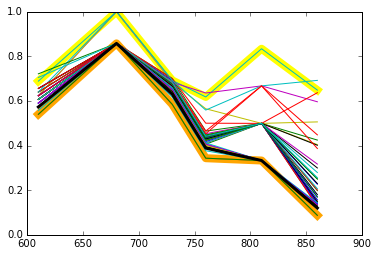

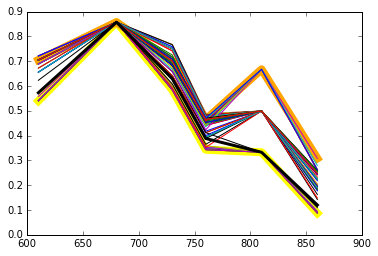

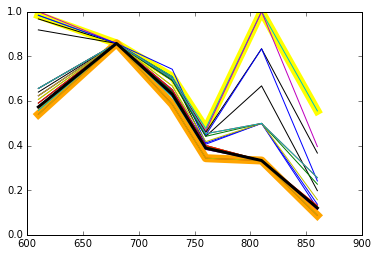

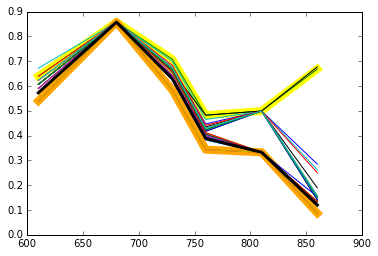

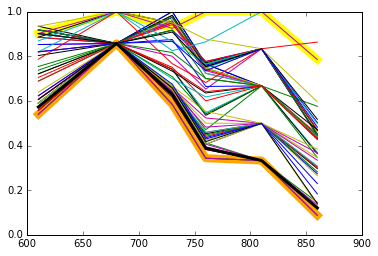

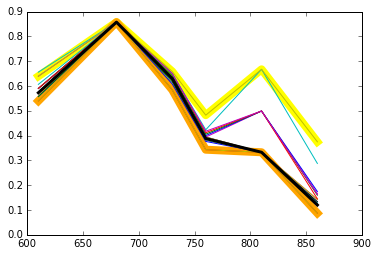

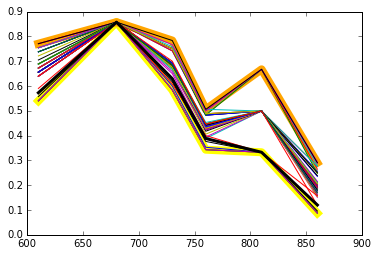

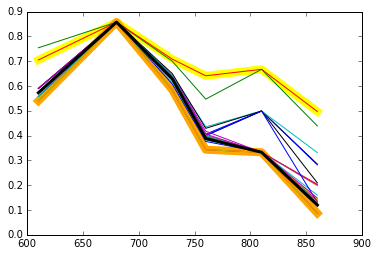

In [178]:
SpectralPlotsWithEndmembers(dataCubesWithBackground, 'NFINDR',endmember_dicts)


In [180]:
#DECISION: USE ENDMEMBERS SUPPLIED BY NFINDR ALGORITHM 
fully_constrained_abundance_map_dict = {}

def makeAbundanceMaps(cube,endmember_dicts):
    for sample in cube:
        data = cube[sample]
        endmember_indices = NFINDR_dict[sample]
        endmembers = np.array([data[b][a] for (a,b) in endmember_indices])

        unmixed_fully_constrained = amap.FCLS()
        fully_constrained_abundance_map = unmixed_fully_constrained.map(data, endmembers) 
        fully_constrained_abundance_map_dict[sample] = fully_constrained_abundance_map
        
        #os.mkdir('../ML_TestDataResults/AbundanceMapsNormalized/' + sample)
        #unmixed_fully_constrained.plot('../ML_TestDataResults/AbundanceMapsNormalized/' + sample)
makeAbundanceMaps(normalizedDataCubesWithBackground,endmember_normalized_dicts)

In [181]:
#small hack to determine which endmember corresponds to the black background based on me 
#manually adding a column of black pixels to the data array

def whichisblack(abundance_map):
    black = 0
    #print "which is black? " + str(abundance_map[0][16][0]) + 'vs.' + str(abundance_map[0][16][1])
    if abundance_map[0][16][0] > 0.94:
        return 0
    elif abundance_map[0][16][1] > 0.94: 
        return 1
    else:
        return "error"

In [182]:
#NEXT DECISION: USE FULLY CONSTRAINED MAP (IE NON NEGATIVE AND SUMS TO 1)

pure_signal_dict = {}
black_endmember = backgroundCubes['VelvetClose(UseForAllSmall)']
normalized_black_endmember = backgroundCubes['VelvetClose(UseForAllSmall)'] / NormalizationMaxVals
def extractSignalFromBackground(cube,endmember_dict,my_black_endmember):
    for sample in cube: 
        #note that this dict is set based on how makeabundancemap function above is run (ie/normalized vs not)
        abundance_map = fully_constrained_abundance_map_dict[sample]
        endmember_indices = endmember_dict[sample]
        data = dataCubesWithBackground[sample]
        endmembers = np.array([data[b][a] for (a,b) in endmember_indices])

        #print abundance_map
        black = whichisblack(abundance_map)
        #print black
        if black == 0:
            signal = 1
        else:
            signal = 0

        pixels = []
        for i, row in enumerate(cube[sample]): 
            for j, pixel in enumerate(row): 
                #print pixel
                #note how below I'm using my far reading endmember for all samples. Could be worth correcting
                #but based on the plots I've seen, the black readings are close enough to each other relative to signal
                #that I'm not extremely worried for my first round of analysis 
                #print i
                #print j
                #print signal
                if abundance_map[i][j][signal] > 0.75:
                    extracted_signal_in_pixel = (cube[sample][i][j] - abundance_map[i][j][black] * my_black_endmember ) / abundance_map[i][j][signal]
                    pixels.append(extracted_signal_in_pixel)
        print 'adding ' + str(len(pixels)) + ' pixels to ' + sample           
        pure_signal_dict[sample] = pixels

extractSignalFromBackground(normalizedDataCubesWithBackground,endmember_normalized_dicts['NFINDR'],normalized_black_endmember)  

adding 3 pixels to Loongana
adding 9 pixels to Chondrite
adding 2 pixels to Gibeon
adding 2 pixels to Toluca
adding 4 pixels to Allende
adding 2 pixels to Abee
adding 8 pixels to Bronzite
adding 2 pixels to Millbillillie


In [185]:
print pure_signal_dict['Toluca']
np.save('../ML_TestData_pure_signal_dict.npy', pure_signal_dict)  

[array([ 0.63945334,  0.85750002,  0.7084315 ,  0.48248305,  0.49938288,
        0.66921146]), array([ 0.60693903,  0.85749998,  0.65867859,  0.48342269,  0.50104383,
        0.68350987])]


In [ ]:
colors = get_spaced_colors(100) 
band = np.array([610,680,730,760,810,860])
#highestthreshold: 0.85
#highthreshold: 0.75
#lowthreshold: 0.5
def plotExtractedSignals(pure_signal_dict):
    print len(pure_signal_dict)
    for sample in pure_signal_dict:
        plt.clf()
        data = pure_signal_dict[sample]
        print sample
        print np.shape(data)
        plt.plot(band,np.transpose(data))
        plt.title(sample)
        plt.ylim([0,1])
        plt.show()
        #os.mkdir('./' + sample)
        #plt.savefig('../ML_TestDataResults/NormalizedExtractedSignalsLowThreshold0to1/' + sample)
         

plotExtractedSignals(pure_signal_dict)
#plotPureSignals(pure_signal_dict)
#NOTE: HORRIBLE HORRIBLE RESULTS!!! Maybe try just non negative constrained? 
#DECISION FOR NOW: USE CLASSIFICATION INSTEAD 

In [ ]:
purest_pixels_dict = {}

def populatePurestPixelsDict(cube):
    classification = clssf.AbundanceClassification()
    for sample in cube:
        abundancemap = fully_constrained_abundance_map_dict[sample]
        classified_pixels = classification.classify(abundancemap,0.2)

        black = classified_pixels[0][16]
        if black == 2: 
            signal = 1
        else:
            signal = 2
        pixel_array = []
        for i,row in enumerate(classified_pixels): 
            for j,column in enumerate(row):
                if classified_pixels[i][j] == signal: 
                    pixel_array.append(cube[sample][i][j])
        purest_pixels_dict[sample] = pixel_array
    #classification.plot('./ExtractedSignals/' + sample + '/')
#print np.shape(dataCubesWithBackground['Allende'])
#print np.shape(purest_pixels_dict['Allende'])
populatePurestPixelsDict(dataCubesWithBackground)

In [ ]:
def plot_purest_pixels(purest_pixels_dict):
    for sample in purest_pixels_dict: 
        plt.plot(band,np.transpose(purest_pixels_dict[sample]))
        plt.show()
        #plt.savefig('../Results/NormalizedPurestPixels2/' + sample)
        plt.clf()
        
plot_purest_pixels(pure_signal_dict)

In [ ]:
samplelist = []
def getNormalizationMaxVals(purest_pixels_dict):
    for sample in purest_pixels_dict:
        for row in purest_pixels_dict[sample]:
            samplelist.append(row)
    return np.array(np.amax(samplelist, axis=0))
NormalizationMaxVals = getNormalizationMaxVals(pure_signal_dict)

In [ ]:
def plot_purest_pixels_normalized(purest_pixels_dict):
    max_vals = NormalizationMaxVals
    #print np.shape(max_vals)
    for sample in purest_pixels_dict: 
        normalized_data = np.array(purest_pixels_dict[sample]) / np.array(max_vals)
        normalized_data_transpose = np.transpose(normalized_data)
        #print np.shape(normalized_data_transpose)
        plt.plot(band,normalized_data_transpose)
        plt.title(sample)
        plt.show()
        #os.mkdir('./Results/PurestPixelsNormalized/' + sample)
        #plt.savefig('../ML_TestDataResults/LateNormalizedExtractedSignalsLowThreshold/' + sample)
        plt.clf()
        
plot_purest_pixels_normalized(pure_signal_dict)